In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

import time
import os
import cv2

img_height = 64
img_width = 64
batch_size = 32

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 5064 files belonging to 2 classes.


In [8]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 967 files belonging to 2 classes.


In [9]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [10]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 114216 files belonging to 2 classes.


In [11]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


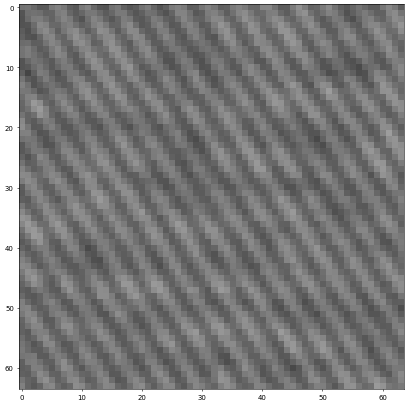

tf.Tensor(
[[[114. 114. 114.]
  [117. 117. 117.]
  [104. 104. 104.]
  ...
  [136. 136. 136.]
  [121. 121. 121.]
  [ 94.  94.  94.]]

 [[ 84.  84.  84.]
  [111. 111. 111.]
  [114. 114. 114.]
  ...
  [131. 131. 131.]
  [139. 139. 139.]
  [116. 116. 116.]]

 [[ 82.  82.  82.]
  [106. 106. 106.]
  [123. 123. 123.]
  ...
  [119. 119. 119.]
  [140. 140. 140.]
  [134. 134. 134.]]

 ...

 [[ 97.  97.  97.]
  [ 94.  94.  94.]
  [114. 114. 114.]
  ...
  [ 90.  90.  90.]
  [118. 118. 118.]
  [137. 137. 137.]]

 [[117. 117. 117.]
  [100. 100. 100.]
  [ 94.  94.  94.]
  ...
  [106. 106. 106.]
  [110. 110. 110.]
  [133. 133. 133.]]

 [[128. 128. 128.]
  [100. 100. 100.]
  [ 89.  89.  89.]
  ...
  [120. 120. 120.]
  [113. 113. 113.]
  [121. 121. 121.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


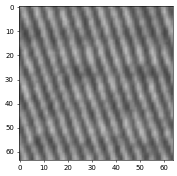

tf.Tensor(
[[[152. 152. 152.]
  [165. 165. 165.]
  [138. 138. 138.]
  ...
  [122. 122. 122.]
  [ 93.  93.  93.]
  [101. 101. 101.]]

 [[125. 125. 125.]
  [156. 156. 156.]
  [153. 153. 153.]
  ...
  [125. 125. 125.]
  [ 89.  89.  89.]
  [ 89.  89.  89.]]

 [[109. 109. 109.]
  [151. 151. 151.]
  [166. 166. 166.]
  ...
  [141. 141. 141.]
  [ 99.  99.  99.]
  [ 85.  85.  85.]]

 ...

 [[113. 113. 113.]
  [155. 155. 155.]
  [157. 157. 157.]
  ...
  [110. 110. 110.]
  [ 89.  89.  89.]
  [105. 105. 105.]]

 [[ 98.  98.  98.]
  [148. 148. 148.]
  [170. 170. 170.]
  ...
  [131. 131. 131.]
  [ 99.  99.  99.]
  [ 86.  86.  86.]]

 [[ 95.  95.  95.]
  [148. 148. 148.]
  [178. 178. 178.]
  ...
  [157. 157. 157.]
  [110. 110. 110.]
  [ 86.  86.  86.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


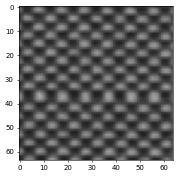

tf.Tensor(
[[[ 88.  88.  88.]
  [ 56.  56.  56.]
  [ 42.  42.  42.]
  ...
  [ 57.  57.  57.]
  [ 62.  62.  62.]
  [ 72.  72.  72.]]

 [[112. 112. 112.]
  [ 76.  76.  76.]
  [ 43.  43.  43.]
  ...
  [ 40.  40.  40.]
  [ 57.  57.  57.]
  [104. 104. 104.]]

 [[ 89.  89.  89.]
  [ 69.  69.  69.]
  [ 52.  52.  52.]
  ...
  [ 54.  54.  54.]
  [ 72.  72.  72.]
  [110. 110. 110.]]

 ...

 [[100. 100. 100.]
  [ 82.  82.  82.]
  [ 65.  65.  65.]
  ...
  [ 59.  59.  59.]
  [ 67.  67.  67.]
  [ 81.  81.  81.]]

 [[ 43.  43.  43.]
  [ 52.  52.  52.]
  [ 73.  73.  73.]
  ...
  [ 74.  74.  74.]
  [ 72.  72.  72.]
  [ 85.  85.  85.]]

 [[ 39.  39.  39.]
  [ 52.  52.  52.]
  [100. 100. 100.]
  ...
  [122. 122. 122.]
  [106. 106. 106.]
  [ 93.  93.  93.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


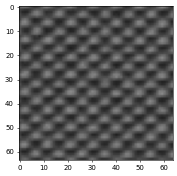

tf.Tensor(
[[[ 98.  98.  98.]
  [105. 105. 105.]
  [104. 104. 104.]
  ...
  [ 96.  96.  96.]
  [ 69.  69.  69.]
  [ 50.  50.  50.]]

 [[ 64.  64.  64.]
  [ 57.  57.  57.]
  [ 50.  50.  50.]
  ...
  [ 62.  62.  62.]
  [ 55.  55.  55.]
  [ 66.  66.  66.]]

 [[ 59.  59.  59.]
  [ 39.  39.  39.]
  [ 35.  35.  35.]
  ...
  [ 42.  42.  42.]
  [ 64.  64.  64.]
  [ 90.  90.  90.]]

 ...

 [[ 69.  69.  69.]
  [ 58.  58.  58.]
  [ 55.  55.  55.]
  ...
  [ 69.  69.  69.]
  [ 97.  97.  97.]
  [122. 122. 122.]]

 [[ 73.  73.  73.]
  [ 83.  83.  83.]
  [ 78.  78.  78.]
  ...
  [ 72.  72.  72.]
  [ 91.  91.  91.]
  [116. 116. 116.]]

 [[ 77.  77.  77.]
  [ 97.  97.  97.]
  [103. 103. 103.]
  ...
  [ 74.  74.  74.]
  [ 72.  72.  72.]
  [ 70.  70.  70.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


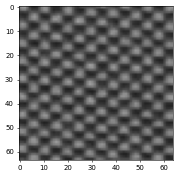

tf.Tensor(
[[[135. 135. 135.]
  [149. 149. 149.]
  [152. 152. 152.]
  ...
  [131. 131. 131.]
  [147. 147. 147.]
  [151. 151. 151.]]

 [[109. 109. 109.]
  [127. 127. 127.]
  [127. 127. 127.]
  ...
  [124. 124. 124.]
  [141. 141. 141.]
  [129. 129. 129.]]

 [[ 60.  60.  60.]
  [ 59.  59.  59.]
  [ 65.  65.  65.]
  ...
  [ 93.  93.  93.]
  [ 96.  96.  96.]
  [ 87.  87.  87.]]

 ...

 [[ 53.  53.  53.]
  [ 52.  52.  52.]
  [ 54.  54.  54.]
  ...
  [ 76.  76.  76.]
  [ 82.  82.  82.]
  [ 90.  90.  90.]]

 [[ 46.  46.  46.]
  [ 47.  47.  47.]
  [ 47.  47.  47.]
  ...
  [ 40.  40.  40.]
  [ 37.  37.  37.]
  [ 45.  45.  45.]]

 [[ 74.  74.  74.]
  [ 77.  77.  77.]
  [ 65.  65.  65.]
  ...
  [ 43.  43.  43.]
  [ 39.  39.  39.]
  [ 39.  39.  39.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


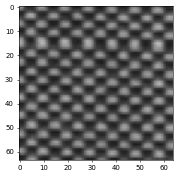

tf.Tensor(
[[[156. 156. 156.]
  [132. 132. 132.]
  [ 70.  70.  70.]
  ...
  [ 41.  41.  41.]
  [ 42.  42.  42.]
  [ 48.  48.  48.]]

 [[118. 118. 118.]
  [ 94.  94.  94.]
  [ 68.  68.  68.]
  ...
  [ 39.  39.  39.]
  [ 36.  36.  36.]
  [ 37.  37.  37.]]

 [[ 43.  43.  43.]
  [ 41.  41.  41.]
  [ 57.  57.  57.]
  ...
  [ 57.  57.  57.]
  [ 61.  61.  61.]
  [ 67.  67.  67.]]

 ...

 [[ 92.  92.  92.]
  [102. 102. 102.]
  [ 80.  80.  80.]
  ...
  [ 46.  46.  46.]
  [ 39.  39.  39.]
  [ 38.  38.  38.]]

 [[ 33.  33.  33.]
  [ 35.  35.  35.]
  [ 45.  45.  45.]
  ...
  [ 68.  68.  68.]
  [ 52.  52.  52.]
  [ 55.  55.  55.]]

 [[ 35.  35.  35.]
  [ 38.  38.  38.]
  [ 56.  56.  56.]
  ...
  [ 57.  57.  57.]
  [ 67.  67.  67.]
  [ 73.  73.  73.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


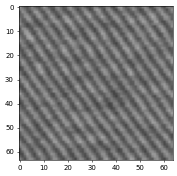

tf.Tensor(
[[[145. 145. 145.]
  [113. 113. 113.]
  [ 93.  93.  93.]
  ...
  [115. 115. 115.]
  [130. 130. 130.]
  [121. 121. 121.]]

 [[129. 129. 129.]
  [133. 133. 133.]
  [113. 113. 113.]
  ...
  [ 77.  77.  77.]
  [110. 110. 110.]
  [141. 141. 141.]]

 [[100. 100. 100.]
  [143. 143. 143.]
  [134. 134. 134.]
  ...
  [ 93.  93.  93.]
  [ 99.  99.  99.]
  [123. 123. 123.]]

 ...

 [[ 73.  73.  73.]
  [ 75.  75.  75.]
  [122. 122. 122.]
  ...
  [148. 148. 148.]
  [127. 127. 127.]
  [105. 105. 105.]]

 [[ 97.  97.  97.]
  [ 79.  79.  79.]
  [ 96.  96.  96.]
  ...
  [136. 136. 136.]
  [134. 134. 134.]
  [121. 121. 121.]]

 [[127. 127. 127.]
  [100. 100. 100.]
  [ 77.  77.  77.]
  ...
  [103. 103. 103.]
  [138. 138. 138.]
  [126. 126. 126.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


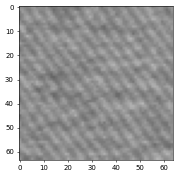

tf.Tensor(
[[[143. 143. 143.]
  [140. 140. 140.]
  [132. 132. 132.]
  ...
  [127. 127. 127.]
  [145. 145. 145.]
  [152. 152. 152.]]

 [[149. 149. 149.]
  [153. 153. 153.]
  [139. 139. 139.]
  ...
  [111. 111. 111.]
  [128. 128. 128.]
  [148. 148. 148.]]

 [[130. 130. 130.]
  [156. 156. 156.]
  [150. 150. 150.]
  ...
  [120. 120. 120.]
  [116. 116. 116.]
  [140. 140. 140.]]

 ...

 [[126. 126. 126.]
  [128. 128. 128.]
  [132. 132. 132.]
  ...
  [180. 180. 180.]
  [173. 173. 173.]
  [151. 151. 151.]]

 [[136. 136. 136.]
  [131. 131. 131.]
  [117. 117. 117.]
  ...
  [153. 153. 153.]
  [159. 159. 159.]
  [156. 156. 156.]]

 [[147. 147. 147.]
  [126. 126. 126.]
  [112. 112. 112.]
  ...
  [143. 143. 143.]
  [151. 151. 151.]
  [157. 157. 157.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


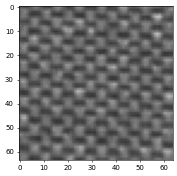

tf.Tensor(
[[[ 83.  83.  83.]
  [ 87.  87.  87.]
  [ 79.  79.  79.]
  ...
  [ 99.  99.  99.]
  [114. 114. 114.]
  [124. 124. 124.]]

 [[108. 108. 108.]
  [117. 117. 117.]
  [119. 119. 119.]
  ...
  [110. 110. 110.]
  [132. 132. 132.]
  [143. 143. 143.]]

 [[ 99.  99.  99.]
  [119. 119. 119.]
  [131. 131. 131.]
  ...
  [111. 111. 111.]
  [114. 114. 114.]
  [109. 109. 109.]]

 ...

 [[110. 110. 110.]
  [114. 114. 114.]
  [111. 111. 111.]
  ...
  [150. 150. 150.]
  [147. 147. 147.]
  [128. 128. 128.]]

 [[109. 109. 109.]
  [124. 124. 124.]
  [122. 122. 122.]
  ...
  [130. 130. 130.]
  [130. 130. 130.]
  [113. 113. 113.]]

 [[111. 111. 111.]
  [120. 120. 120.]
  [115. 115. 115.]
  ...
  [117. 117. 117.]
  [113. 113. 113.]
  [110. 110. 110.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


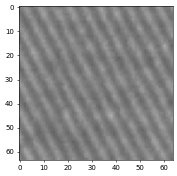

tf.Tensor(
[[[124. 124. 124.]
  [137. 137. 137.]
  [147. 147. 147.]
  ...
  [120. 120. 120.]
  [127. 127. 127.]
  [150. 150. 150.]]

 [[121. 121. 121.]
  [127. 127. 127.]
  [145. 145. 145.]
  ...
  [118. 118. 118.]
  [117. 117. 117.]
  [141. 141. 141.]]

 [[110. 110. 110.]
  [122. 122. 122.]
  [132. 132. 132.]
  ...
  [117. 117. 117.]
  [114. 114. 114.]
  [124. 124. 124.]]

 ...

 [[119. 119. 119.]
  [125. 125. 125.]
  [149. 149. 149.]
  ...
  [131. 131. 131.]
  [123. 123. 123.]
  [120. 120. 120.]]

 [[127. 127. 127.]
  [118. 118. 118.]
  [135. 135. 135.]
  ...
  [131. 131. 131.]
  [122. 122. 122.]
  [117. 117. 117.]]

 [[131. 131. 131.]
  [120. 120. 120.]
  [124. 124. 124.]
  ...
  [139. 139. 139.]
  [124. 124. 124.]
  [110. 110. 110.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


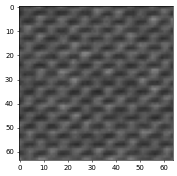

tf.Tensor(
[[[ 68.  68.  68.]
  [ 67.  67.  67.]
  [ 72.  72.  72.]
  ...
  [ 71.  71.  71.]
  [ 75.  75.  75.]
  [ 84.  84.  84.]]

 [[ 63.  63.  63.]
  [ 70.  70.  70.]
  [ 87.  87.  87.]
  ...
  [ 98.  98.  98.]
  [ 91.  91.  91.]
  [ 83.  83.  83.]]

 [[ 49.  49.  49.]
  [ 60.  60.  60.]
  [ 74.  74.  74.]
  ...
  [ 95.  95.  95.]
  [ 79.  79.  79.]
  [ 61.  61.  61.]]

 ...

 [[ 58.  58.  58.]
  [ 61.  61.  61.]
  [ 74.  74.  74.]
  ...
  [101. 101. 101.]
  [ 85.  85.  85.]
  [ 71.  71.  71.]]

 [[ 86.  86.  86.]
  [ 80.  80.  80.]
  [ 83.  83.  83.]
  ...
  [ 93.  93.  93.]
  [ 87.  87.  87.]
  [ 74.  74.  74.]]

 [[111. 111. 111.]
  [ 87.  87.  87.]
  [ 78.  78.  78.]
  ...
  [ 77.  77.  77.]
  [ 77.  77.  77.]
  [ 88.  88.  88.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


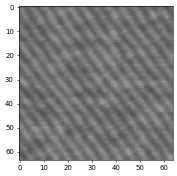

tf.Tensor(
[[[118. 118. 118.]
  [108. 108. 108.]
  [100. 100. 100.]
  ...
  [ 89.  89.  89.]
  [ 99.  99.  99.]
  [112. 112. 112.]]

 [[129. 129. 129.]
  [132. 132. 132.]
  [111. 111. 111.]
  ...
  [ 95.  95.  95.]
  [ 88.  88.  88.]
  [100. 100. 100.]]

 [[116. 116. 116.]
  [127. 127. 127.]
  [119. 119. 119.]
  ...
  [116. 116. 116.]
  [ 94.  94.  94.]
  [ 98.  98.  98.]]

 ...

 [[ 83.  83.  83.]
  [ 91.  91.  91.]
  [107. 107. 107.]
  ...
  [134. 134. 134.]
  [133. 133. 133.]
  [112. 112. 112.]]

 [[101. 101. 101.]
  [ 81.  81.  81.]
  [ 89.  89.  89.]
  ...
  [128. 128. 128.]
  [153. 153. 153.]
  [149. 149. 149.]]

 [[118. 118. 118.]
  [100. 100. 100.]
  [ 94.  94.  94.]
  ...
  [118. 118. 118.]
  [141. 141. 141.]
  [147. 147. 147.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


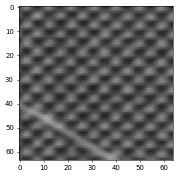

tf.Tensor(
[[[ 73.  73.  73.]
  [106. 106. 106.]
  [129. 129. 129.]
  ...
  [ 81.  81.  81.]
  [ 55.  55.  55.]
  [ 39.  39.  39.]]

 [[ 86.  86.  86.]
  [ 99.  99.  99.]
  [110. 110. 110.]
  ...
  [ 90.  90.  90.]
  [ 66.  66.  66.]
  [ 60.  60.  60.]]

 [[ 83.  83.  83.]
  [ 65.  65.  65.]
  [ 61.  61.  61.]
  ...
  [ 68.  68.  68.]
  [ 74.  74.  74.]
  [ 87.  87.  87.]]

 ...

 [[ 85.  85.  85.]
  [108. 108. 108.]
  [119. 119. 119.]
  ...
  [ 94.  94.  94.]
  [ 64.  64.  64.]
  [ 52.  52.  52.]]

 [[ 81.  81.  81.]
  [ 75.  75.  75.]
  [ 73.  73.  73.]
  ...
  [ 88.  88.  88.]
  [ 78.  78.  78.]
  [ 67.  67.  67.]]

 [[ 80.  80.  80.]
  [ 54.  54.  54.]
  [ 46.  46.  46.]
  ...
  [ 71.  71.  71.]
  [ 75.  75.  75.]
  [ 81.  81.  81.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


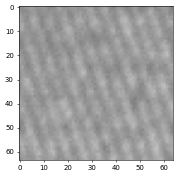

tf.Tensor(
[[[142. 142. 142.]
  [145. 145. 145.]
  [151. 151. 151.]
  ...
  [154. 154. 154.]
  [145. 145. 145.]
  [127. 127. 127.]]

 [[144. 144. 144.]
  [137. 137. 137.]
  [142. 142. 142.]
  ...
  [152. 152. 152.]
  [143. 143. 143.]
  [134. 134. 134.]]

 [[149. 149. 149.]
  [142. 142. 142.]
  [141. 141. 141.]
  ...
  [156. 156. 156.]
  [139. 139. 139.]
  [137. 137. 137.]]

 ...

 [[152. 152. 152.]
  [160. 160. 160.]
  [166. 166. 166.]
  ...
  [142. 142. 142.]
  [149. 149. 149.]
  [158. 158. 158.]]

 [[153. 153. 153.]
  [157. 157. 157.]
  [156. 156. 156.]
  ...
  [142. 142. 142.]
  [143. 143. 143.]
  [153. 153. 153.]]

 [[142. 142. 142.]
  [153. 153. 153.]
  [157. 157. 157.]
  ...
  [139. 139. 139.]
  [138. 138. 138.]
  [144. 144. 144.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


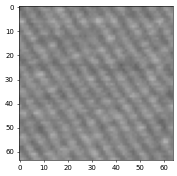

tf.Tensor(
[[[108. 108. 108.]
  [120. 120. 120.]
  [134. 134. 134.]
  ...
  [147. 147. 147.]
  [139. 139. 139.]
  [127. 127. 127.]]

 [[103. 103. 103.]
  [116. 116. 116.]
  [128. 128. 128.]
  ...
  [159. 159. 159.]
  [147. 147. 147.]
  [135. 135. 135.]]

 [[128. 128. 128.]
  [119. 119. 119.]
  [116. 116. 116.]
  ...
  [140. 140. 140.]
  [149. 149. 149.]
  [142. 142. 142.]]

 ...

 [[149. 149. 149.]
  [128. 128. 128.]
  [118. 118. 118.]
  ...
  [128. 128. 128.]
  [140. 140. 140.]
  [143. 143. 143.]]

 [[144. 144. 144.]
  [137. 137. 137.]
  [128. 128. 128.]
  ...
  [118. 118. 118.]
  [125. 125. 125.]
  [133. 133. 133.]]

 [[153. 153. 153.]
  [156. 156. 156.]
  [141. 141. 141.]
  ...
  [120. 120. 120.]
  [128. 128. 128.]
  [131. 131. 131.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


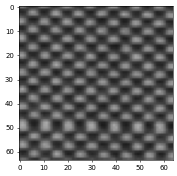

tf.Tensor(
[[[110. 110. 110.]
  [115. 115. 115.]
  [100. 100. 100.]
  ...
  [ 53.  53.  53.]
  [ 43.  43.  43.]
  [ 46.  46.  46.]]

 [[ 47.  47.  47.]
  [ 51.  51.  51.]
  [ 57.  57.  57.]
  ...
  [ 71.  71.  71.]
  [ 67.  67.  67.]
  [ 58.  58.  58.]]

 [[ 40.  40.  40.]
  [ 39.  39.  39.]
  [ 46.  46.  46.]
  ...
  [ 92.  92.  92.]
  [106. 106. 106.]
  [ 98.  98.  98.]]

 ...

 [[ 52.  52.  52.]
  [ 42.  42.  42.]
  [ 48.  48.  48.]
  ...
  [ 75.  75.  75.]
  [118. 118. 118.]
  [135. 135. 135.]]

 [[ 67.  67.  67.]
  [ 67.  67.  67.]
  [ 64.  64.  64.]
  ...
  [ 90.  90.  90.]
  [132. 132. 132.]
  [146. 146. 146.]]

 [[ 97.  97.  97.]
  [110. 110. 110.]
  [105. 105. 105.]
  ...
  [ 88.  88.  88.]
  [105. 105. 105.]
  [119. 119. 119.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


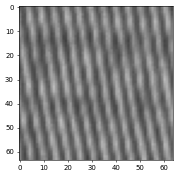

tf.Tensor(
[[[ 93.  93.  93.]
  [ 87.  87.  87.]
  [110. 110. 110.]
  ...
  [154. 154. 154.]
  [107. 107. 107.]
  [ 78.  78.  78.]]

 [[ 99.  99.  99.]
  [ 87.  87.  87.]
  [ 93.  93.  93.]
  ...
  [156. 156. 156.]
  [112. 112. 112.]
  [ 74.  74.  74.]]

 [[112. 112. 112.]
  [ 83.  83.  83.]
  [ 91.  91.  91.]
  ...
  [163. 163. 163.]
  [126. 126. 126.]
  [ 89.  89.  89.]]

 ...

 [[131. 131. 131.]
  [ 90.  90.  90.]
  [ 70.  70.  70.]
  ...
  [163. 163. 163.]
  [143. 143. 143.]
  [104. 104. 104.]]

 [[130. 130. 130.]
  [ 90.  90.  90.]
  [ 71.  71.  71.]
  ...
  [158. 158. 158.]
  [149. 149. 149.]
  [106. 106. 106.]]

 [[131. 131. 131.]
  [ 92.  92.  92.]
  [ 74.  74.  74.]
  ...
  [148. 148. 148.]
  [155. 155. 155.]
  [117. 117. 117.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


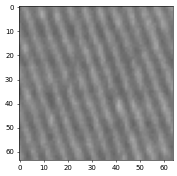

tf.Tensor(
[[[119. 119. 119.]
  [141. 141. 141.]
  [142. 142. 142.]
  ...
  [130. 130. 130.]
  [147. 147. 147.]
  [152. 152. 152.]]

 [[112. 112. 112.]
  [138. 138. 138.]
  [147. 147. 147.]
  ...
  [119. 119. 119.]
  [136. 136. 136.]
  [150. 150. 150.]]

 [[119. 119. 119.]
  [126. 126. 126.]
  [140. 140. 140.]
  ...
  [118. 118. 118.]
  [133. 133. 133.]
  [135. 135. 135.]]

 ...

 [[148. 148. 148.]
  [130. 130. 130.]
  [114. 114. 114.]
  ...
  [143. 143. 143.]
  [135. 135. 135.]
  [120. 120. 120.]]

 [[148. 148. 148.]
  [139. 139. 139.]
  [119. 119. 119.]
  ...
  [130. 130. 130.]
  [134. 134. 134.]
  [119. 119. 119.]]

 [[148. 148. 148.]
  [135. 135. 135.]
  [115. 115. 115.]
  ...
  [128. 128. 128.]
  [125. 125. 125.]
  [118. 118. 118.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


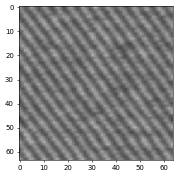

tf.Tensor(
[[[155. 155. 155.]
  [119. 119. 119.]
  [ 95.  95.  95.]
  ...
  [109. 109. 109.]
  [136. 136. 136.]
  [140. 140. 140.]]

 [[131. 131. 131.]
  [130. 130. 130.]
  [ 97.  97.  97.]
  ...
  [ 93.  93.  93.]
  [119. 119. 119.]
  [154. 154. 154.]]

 [[114. 114. 114.]
  [144. 144. 144.]
  [120. 120. 120.]
  ...
  [ 96.  96.  96.]
  [ 98.  98.  98.]
  [118. 118. 118.]]

 ...

 [[105. 105. 105.]
  [ 97.  97.  97.]
  [131. 131. 131.]
  ...
  [164. 164. 164.]
  [136. 136. 136.]
  [101. 101. 101.]]

 [[117. 117. 117.]
  [ 97.  97.  97.]
  [119. 119. 119.]
  ...
  [146. 146. 146.]
  [165. 165. 165.]
  [125. 125. 125.]]

 [[154. 154. 154.]
  [119. 119. 119.]
  [ 95.  95.  95.]
  ...
  [131. 131. 131.]
  [148. 148. 148.]
  [142. 142. 142.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


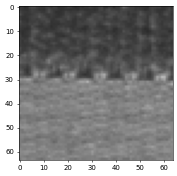

tf.Tensor(
[[[ 56.  56.  56.]
  [ 56.  56.  56.]
  [ 46.  46.  46.]
  ...
  [ 57.  57.  57.]
  [ 65.  65.  65.]
  [ 51.  51.  51.]]

 [[ 60.  60.  60.]
  [ 54.  54.  54.]
  [ 51.  51.  51.]
  ...
  [ 61.  61.  61.]
  [ 71.  71.  71.]
  [ 58.  58.  58.]]

 [[ 69.  69.  69.]
  [ 59.  59.  59.]
  [ 57.  57.  57.]
  ...
  [ 70.  70.  70.]
  [ 67.  67.  67.]
  [ 54.  54.  54.]]

 ...

 [[136. 136. 136.]
  [134. 134. 134.]
  [140. 140. 140.]
  ...
  [123. 123. 123.]
  [128. 128. 128.]
  [132. 132. 132.]]

 [[131. 131. 131.]
  [129. 129. 129.]
  [124. 124. 124.]
  ...
  [132. 132. 132.]
  [123. 123. 123.]
  [133. 133. 133.]]

 [[125. 125. 125.]
  [137. 137. 137.]
  [137. 137. 137.]
  ...
  [133. 133. 133.]
  [139. 139. 139.]
  [132. 132. 132.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


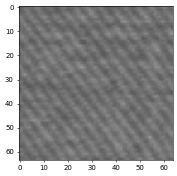

tf.Tensor(
[[[ 97.  97.  97.]
  [106. 106. 106.]
  [111. 111. 111.]
  ...
  [121. 121. 121.]
  [106. 106. 106.]
  [114. 114. 114.]]

 [[ 93.  93.  93.]
  [103. 103. 103.]
  [120. 120. 120.]
  ...
  [107. 107. 107.]
  [101. 101. 101.]
  [ 99.  99.  99.]]

 [[ 99.  99.  99.]
  [ 99.  99.  99.]
  [106. 106. 106.]
  ...
  [119. 119. 119.]
  [114. 114. 114.]
  [109. 109. 109.]]

 ...

 [[116. 116. 116.]
  [123. 123. 123.]
  [102. 102. 102.]
  ...
  [113. 113. 113.]
  [122. 122. 122.]
  [125. 125. 125.]]

 [[103. 103. 103.]
  [109. 109. 109.]
  [112. 112. 112.]
  ...
  [110. 110. 110.]
  [114. 114. 114.]
  [128. 128. 128.]]

 [[ 99.  99.  99.]
  [106. 106. 106.]
  [111. 111. 111.]
  ...
  [113. 113. 113.]
  [ 99.  99.  99.]
  [101. 101. 101.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


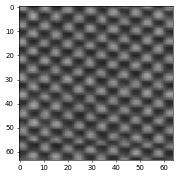

tf.Tensor(
[[[134. 134. 134.]
  [149. 149. 149.]
  [145. 145. 145.]
  ...
  [129. 129. 129.]
  [138. 138. 138.]
  [139. 139. 139.]]

 [[122. 122. 122.]
  [140. 140. 140.]
  [131. 131. 131.]
  ...
  [120. 120. 120.]
  [120. 120. 120.]
  [110. 110. 110.]]

 [[ 61.  61.  61.]
  [ 73.  73.  73.]
  [ 80.  80.  80.]
  ...
  [ 62.  62.  62.]
  [ 63.  63.  63.]
  [ 59.  59.  59.]]

 ...

 [[ 47.  47.  47.]
  [ 55.  55.  55.]
  [ 60.  60.  60.]
  ...
  [ 44.  44.  44.]
  [ 40.  40.  40.]
  [ 37.  37.  37.]]

 [[ 57.  57.  57.]
  [ 67.  67.  67.]
  [ 77.  77.  77.]
  ...
  [ 61.  61.  61.]
  [ 55.  55.  55.]
  [ 57.  57.  57.]]

 [[ 86.  86.  86.]
  [ 87.  87.  87.]
  [ 89.  89.  89.]
  ...
  [ 73.  73.  73.]
  [ 76.  76.  76.]
  [ 80.  80.  80.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


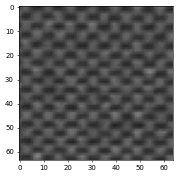

tf.Tensor(
[[[ 66.  66.  66.]
  [ 89.  89.  89.]
  [ 99.  99.  99.]
  ...
  [ 65.  65.  65.]
  [ 52.  52.  52.]
  [ 53.  53.  53.]]

 [[ 79.  79.  79.]
  [ 87.  87.  87.]
  [ 96.  96.  96.]
  ...
  [ 50.  50.  50.]
  [ 39.  39.  39.]
  [ 41.  41.  41.]]

 [[ 93.  93.  93.]
  [ 80.  80.  80.]
  [ 72.  72.  72.]
  ...
  [ 60.  60.  60.]
  [ 62.  62.  62.]
  [ 63.  63.  63.]]

 ...

 [[ 74.  74.  74.]
  [ 69.  69.  69.]
  [ 75.  75.  75.]
  ...
  [ 62.  62.  62.]
  [ 61.  61.  61.]
  [ 59.  59.  59.]]

 [[ 66.  66.  66.]
  [ 49.  49.  49.]
  [ 45.  45.  45.]
  ...
  [ 87.  87.  87.]
  [101. 101. 101.]
  [ 97.  97.  97.]]

 [[ 66.  66.  66.]
  [ 51.  51.  51.]
  [ 57.  57.  57.]
  ...
  [ 80.  80.  80.]
  [ 96.  96.  96.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


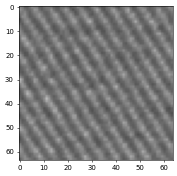

tf.Tensor(
[[[133. 133. 133.]
  [121. 121. 121.]
  [ 95.  95.  95.]
  ...
  [118. 118. 118.]
  [143. 143. 143.]
  [134. 134. 134.]]

 [[146. 146. 146.]
  [129. 129. 129.]
  [113. 113. 113.]
  ...
  [102. 102. 102.]
  [123. 123. 123.]
  [135. 135. 135.]]

 [[128. 128. 128.]
  [123. 123. 123.]
  [131. 131. 131.]
  ...
  [108. 108. 108.]
  [105. 105. 105.]
  [120. 120. 120.]]

 ...

 [[134. 134. 134.]
  [131. 131. 131.]
  [123. 123. 123.]
  ...
  [100. 100. 100.]
  [108. 108. 108.]
  [118. 118. 118.]]

 [[122. 122. 122.]
  [130. 130. 130.]
  [140. 140. 140.]
  ...
  [102. 102. 102.]
  [104. 104. 104.]
  [112. 112. 112.]]

 [[ 99.  99.  99.]
  [120. 120. 120.]
  [141. 141. 141.]
  ...
  [121. 121. 121.]
  [108. 108. 108.]
  [103. 103. 103.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


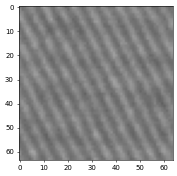

tf.Tensor(
[[[124. 124. 124.]
  [114. 114. 114.]
  [120. 120. 120.]
  ...
  [120. 120. 120.]
  [111. 111. 111.]
  [115. 115. 115.]]

 [[138. 138. 138.]
  [112. 112. 112.]
  [117. 117. 117.]
  ...
  [129. 129. 129.]
  [114. 114. 114.]
  [118. 118. 118.]]

 [[139. 139. 139.]
  [133. 133. 133.]
  [120. 120. 120.]
  ...
  [132. 132. 132.]
  [125. 125. 125.]
  [115. 115. 115.]]

 ...

 [[143. 143. 143.]
  [115. 115. 115.]
  [116. 116. 116.]
  ...
  [146. 146. 146.]
  [145. 145. 145.]
  [129. 129. 129.]]

 [[131. 131. 131.]
  [126. 126. 126.]
  [118. 118. 118.]
  ...
  [142. 142. 142.]
  [142. 142. 142.]
  [130. 130. 130.]]

 [[137. 137. 137.]
  [132. 132. 132.]
  [121. 121. 121.]
  ...
  [138. 138. 138.]
  [142. 142. 142.]
  [134. 134. 134.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


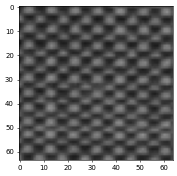

tf.Tensor(
[[[ 40.  40.  40.]
  [ 54.  54.  54.]
  [ 85.  85.  85.]
  ...
  [ 85.  85.  85.]
  [ 81.  81.  81.]
  [ 80.  80.  80.]]

 [[ 47.  47.  47.]
  [ 70.  70.  70.]
  [109. 109. 109.]
  ...
  [126. 126. 126.]
  [112. 112. 112.]
  [ 83.  83.  83.]]

 [[ 55.  55.  55.]
  [ 75.  75.  75.]
  [100. 100. 100.]
  ...
  [142. 142. 142.]
  [121. 121. 121.]
  [ 91.  91.  91.]]

 ...

 [[ 83.  83.  83.]
  [ 66.  66.  66.]
  [ 52.  52.  52.]
  ...
  [100. 100. 100.]
  [ 88.  88.  88.]
  [ 75.  75.  75.]]

 [[101. 101. 101.]
  [ 65.  65.  65.]
  [ 40.  40.  40.]
  ...
  [ 47.  47.  47.]
  [ 46.  46.  46.]
  [ 62.  62.  62.]]

 [[101. 101. 101.]
  [ 69.  69.  69.]
  [ 44.  44.  44.]
  ...
  [ 35.  35.  35.]
  [ 39.  39.  39.]
  [ 65.  65.  65.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


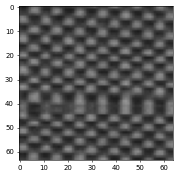

tf.Tensor(
[[[42. 42. 42.]
  [31. 31. 31.]
  [32. 32. 32.]
  ...
  [73. 73. 73.]
  [53. 53. 53.]
  [45. 45. 45.]]

 [[51. 51. 51.]
  [43. 43. 43.]
  [46. 46. 46.]
  ...
  [84. 84. 84.]
  [74. 74. 74.]
  [69. 69. 69.]]

 [[62. 62. 62.]
  [56. 56. 56.]
  [56. 56. 56.]
  ...
  [81. 81. 81.]
  [90. 90. 90.]
  [87. 87. 87.]]

 ...

 [[34. 34. 34.]
  [37. 37. 37.]
  [32. 32. 32.]
  ...
  [68. 68. 68.]
  [54. 54. 54.]
  [52. 52. 52.]]

 [[45. 45. 45.]
  [44. 44. 44.]
  [41. 41. 41.]
  ...
  [67. 67. 67.]
  [66. 66. 66.]
  [68. 68. 68.]]

 [[58. 58. 58.]
  [58. 58. 58.]
  [56. 56. 56.]
  ...
  [75. 75. 75.]
  [95. 95. 95.]
  [99. 99. 99.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


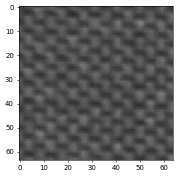

tf.Tensor(
[[[ 69.  69.  69.]
  [ 62.  62.  62.]
  [ 70.  70.  70.]
  ...
  [ 75.  75.  75.]
  [ 57.  57.  57.]
  [ 59.  59.  59.]]

 [[ 72.  72.  72.]
  [ 59.  59.  59.]
  [ 58.  58.  58.]
  ...
  [ 71.  71.  71.]
  [ 58.  58.  58.]
  [ 55.  55.  55.]]

 [[ 76.  76.  76.]
  [ 60.  60.  60.]
  [ 49.  49.  49.]
  ...
  [ 84.  84.  84.]
  [ 81.  81.  81.]
  [ 72.  72.  72.]]

 ...

 [[ 88.  88.  88.]
  [ 72.  72.  72.]
  [ 56.  56.  56.]
  ...
  [ 73.  73.  73.]
  [ 79.  79.  79.]
  [ 82.  82.  82.]]

 [[ 89.  89.  89.]
  [ 79.  79.  79.]
  [ 66.  66.  66.]
  ...
  [ 84.  84.  84.]
  [103. 103. 103.]
  [110. 110. 110.]]

 [[ 77.  77.  77.]
  [ 79.  79.  79.]
  [ 88.  88.  88.]
  ...
  [ 71.  71.  71.]
  [ 96.  96.  96.]
  [112. 112. 112.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


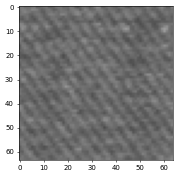

tf.Tensor(
[[[122. 122. 122.]
  [121. 121. 121.]
  [110. 110. 110.]
  ...
  [ 98.  98.  98.]
  [ 98.  98.  98.]
  [124. 124. 124.]]

 [[118. 118. 118.]
  [128. 128. 128.]
  [125. 125. 125.]
  ...
  [107. 107. 107.]
  [105. 105. 105.]
  [113. 113. 113.]]

 [[113. 113. 113.]
  [124. 124. 124.]
  [132. 132. 132.]
  ...
  [118. 118. 118.]
  [110. 110. 110.]
  [112. 112. 112.]]

 ...

 [[108. 108. 108.]
  [104. 104. 104.]
  [113. 113. 113.]
  ...
  [111. 111. 111.]
  [110. 110. 110.]
  [111. 111. 111.]]

 [[109. 109. 109.]
  [119. 119. 119.]
  [107. 107. 107.]
  ...
  [106. 106. 106.]
  [115. 115. 115.]
  [125. 125. 125.]]

 [[120. 120. 120.]
  [116. 116. 116.]
  [110. 110. 110.]
  ...
  [119. 119. 119.]
  [123. 123. 123.]
  [133. 133. 133.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


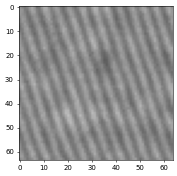

tf.Tensor(
[[[145. 145. 145.]
  [129. 129. 129.]
  [120. 120. 120.]
  ...
  [159. 159. 159.]
  [168. 168. 168.]
  [144. 144. 144.]]

 [[151. 151. 151.]
  [148. 148. 148.]
  [123. 123. 123.]
  ...
  [151. 151. 151.]
  [169. 169. 169.]
  [154. 154. 154.]]

 [[152. 152. 152.]
  [146. 146. 146.]
  [128. 128. 128.]
  ...
  [142. 142. 142.]
  [170. 170. 170.]
  [153. 153. 153.]]

 ...

 [[154. 154. 154.]
  [148. 148. 148.]
  [124. 124. 124.]
  ...
  [144. 144. 144.]
  [158. 158. 158.]
  [141. 141. 141.]]

 [[158. 158. 158.]
  [157. 157. 157.]
  [128. 128. 128.]
  ...
  [138. 138. 138.]
  [156. 156. 156.]
  [151. 151. 151.]]

 [[140. 140. 140.]
  [148. 148. 148.]
  [138. 138. 138.]
  ...
  [122. 122. 122.]
  [144. 144. 144.]
  [155. 155. 155.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


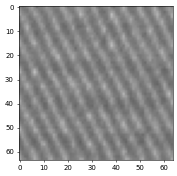

tf.Tensor(
[[[130. 130. 130.]
  [117. 117. 117.]
  [123. 123. 123.]
  ...
  [143. 143. 143.]
  [152. 152. 152.]
  [139. 139. 139.]]

 [[143. 143. 143.]
  [124. 124. 124.]
  [118. 118. 118.]
  ...
  [141. 141. 141.]
  [156. 156. 156.]
  [150. 150. 150.]]

 [[152. 152. 152.]
  [134. 134. 134.]
  [125. 125. 125.]
  ...
  [125. 125. 125.]
  [147. 147. 147.]
  [153. 153. 153.]]

 ...

 [[145. 145. 145.]
  [118. 118. 118.]
  [116. 116. 116.]
  ...
  [136. 136. 136.]
  [158. 158. 158.]
  [146. 146. 146.]]

 [[157. 157. 157.]
  [131. 131. 131.]
  [111. 111. 111.]
  ...
  [135. 135. 135.]
  [144. 144. 144.]
  [151. 151. 151.]]

 [[162. 162. 162.]
  [138. 138. 138.]
  [130. 130. 130.]
  ...
  [126. 126. 126.]
  [134. 134. 134.]
  [165. 165. 165.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


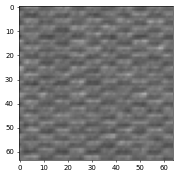

tf.Tensor(
[[[102. 102. 102.]
  [114. 114. 114.]
  [129. 129. 129.]
  ...
  [105. 105. 105.]
  [110. 110. 110.]
  [111. 111. 111.]]

 [[ 83.  83.  83.]
  [ 92.  92.  92.]
  [102. 102. 102.]
  ...
  [ 99.  99.  99.]
  [ 97.  97.  97.]
  [101. 101. 101.]]

 [[115. 115. 115.]
  [118. 118. 118.]
  [101. 101. 101.]
  ...
  [123. 123. 123.]
  [125. 125. 125.]
  [124. 124. 124.]]

 ...

 [[106. 106. 106.]
  [100. 100. 100.]
  [ 91.  91.  91.]
  ...
  [116. 116. 116.]
  [117. 117. 117.]
  [115. 115. 115.]]

 [[116. 116. 116.]
  [115. 115. 115.]
  [132. 132. 132.]
  ...
  [104. 104. 104.]
  [112. 112. 112.]
  [112. 112. 112.]]

 [[112. 112. 112.]
  [121. 121. 121.]
  [123. 123. 123.]
  ...
  [ 85.  85.  85.]
  [ 87.  87.  87.]
  [ 90.  90.  90.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


In [12]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi']     = 50

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(0, len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.show()
        print(images[i])
        print(labels[i])
        print("-----------------------------")
    

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid') # reports inflated acc and tiny loss values
#   layers.Dense(1)

])



In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        3

In [16]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 28s 125ms/step - loss: 0.5177 - accuracy: 0.7561 - val_loss: 0.3799 - val_accuracy: 0.8594
Epoch 2/15
159/159 [==============================] - 22s 139ms/step - loss: 0.4726 - accuracy: 0.7709 - val_loss: 0.4103 - val_accuracy: 0.7735
Epoch 3/15
159/159 [==============================] - 23s 148ms/step - loss: 0.4371 - accuracy: 0.7668 - val_loss: 0.3686 - val_accuracy: 0.7725
Epoch 4/15
159/159 [==============================] - 19s 117ms/step - loss: 0.3743 - accuracy: 0.7948 - val_loss: 0.3436 - val_accuracy: 0.7787
Epoch 5/15
159/159 [==============================] - 25s 155ms/step - loss: 0.3356 - accuracy: 0.8412 - val_loss: 0.2119 - val_accuracy: 0.9173
Epoch 6/15
159/159 [==============================] - 28s 179ms/step - loss: 0.2551 - accuracy: 0.8945 - val_loss: 0.1743 - val_accuracy: 0.9390
Epoch 7/15
159/159 [==============================] - 30s 187ms/step - loss: 0.1936 - accuracy: 0.9204 - val_loss: 0.1560 - val_ac

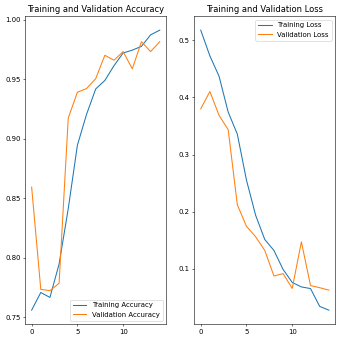

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 51ms/step - loss: 0.0649 - accuracy: 0.9840


{'loss': 0.06491924822330475, 'accuracy': 0.9840425252914429}

In [19]:
# cwd = os.getcwd()
model.save("inspection_model")

#model.save_weights("inspection_weights")

INFO:tensorflow:Assets written to: inspection_model\assets


In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [23]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 26s 153ms/step - loss: 0.5228 - accuracy: 0.7453 - val_loss: 0.4376 - val_accuracy: 0.7797
Epoch 2/15
159/159 [==============================] - 24s 152ms/step - loss: 0.4481 - accuracy: 0.7719 - val_loss: 0.3666 - val_accuracy: 0.7725
Epoch 3/15
159/159 [==============================] - 19s 118ms/step - loss: 0.3837 - accuracy: 0.8112 - val_loss: 0.2232 - val_accuracy: 0.9235
Epoch 4/15
159/159 [==============================] - 19s 121ms/step - loss: 0.2148 - accuracy: 0.9232 - val_loss: 0.1365 - val_accuracy: 0.9566
Epoch 5/15
159/159 [==============================] - 22s 141ms/step - loss: 0.1516 - accuracy: 0.9514 - val_loss: 0.1082 - val_accuracy: 0.9700
Epoch 6/15
159/159 [==============================] - 23s 145ms/step - loss: 0.1187 - accuracy: 0.9645 - val_loss: 0.0991 - val_accuracy: 0.9752
Epoch 7/15
159/159 [==============================] - 23s 145ms/step - loss: 0.0839 - accuracy: 0.9733 - val_loss: 0.0868 - val_ac

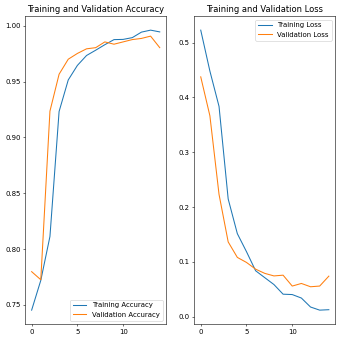

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.save("inspection_model_aug")


INFO:tensorflow:Assets written to: inspection_model_aug\assets


In [26]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 60ms/step - loss: 0.0789 - accuracy: 0.9752


{'loss': 0.0788508877158165, 'accuracy': 0.9751772880554199}

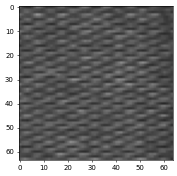

CNN output: [[0.22588405]]
This image most likely belongs to defect with a 77.41 percent confidence.
inference took: 0.3642159000155516 ms


In [27]:
path = "./test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)
print("inference took:", timeTaken,"ms")

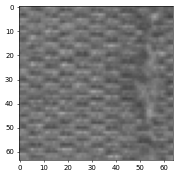

CNN output: [[0.00385973]]
This image most likely belongs to defect with a 99.61 percent confidence.
inference took: 0.11017759999958798 ms


In [28]:
path = "./test_data/defect/defect_1.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

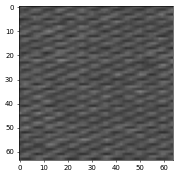

CNN output: [[0.994259]]
This image most likely belongs to normal with a 99.43 percent confidence.
inference took: 0.16892210001242347 ms


In [29]:
path = "./test_data/normal/normal_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

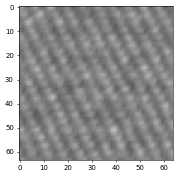

CNN output: [[0.99995923]]
This image most likely belongs to normal with a 100.00 percent confidence.
inference took: 0.12122410000301898 ms


In [30]:
path = "./test_data/normal/normal_1.png"


cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [31]:
# dad got an accarcy of 93% on inspections machines without ai

In [32]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


In [ ]:

result = reconstructed_model.evaluate(test_ds)

dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
path = "./test_data/defect/defect_20.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

Have to change batchsize to properly inspect, not needed if data isnt shuffled

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=True
)

In [ ]:
model = reconstructed_model

preds = model.predict(test_ds,batch_size = 1,
verbose=1)

individualPredicts = []

TP = 0
TN = 0
FP = 0
FN = 0

names = os.listdir("./test_data/defect/")
for name in names:
    path = "./test_data/defect/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 0:
        TP = TP + 1
    else:
        FP = FP + 1
        
    
    
    
names = os.listdir("./test_data/normal/")
for name in names:
    path = "./test_data/normal/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 1:
        TN = TN + 1
    else:
        FN = FN + 1


# print(preds)
# print(individualPredicts)
print(TP, FP)
print(FN, TN)



In [ ]:
predictions = []
targets  = []

start = time.perf_counter()

for image, target in test_ds:
    prediction = model.predict(image)
    targets.append(tf.get_static_value(target)[0][0])
    predictions.append(int(np.rint(prediction[0])))
    
taken = time.perf_counter() - start

print("time using single prediction:", taken)



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()



In [ ]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, _ = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, predictions))

In [ ]:

result = reconstructed_model.evaluate(all_ds)

dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

In [ ]:
predictions = reconstructed_model.predict(all_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
targets = np.concatenate([targets for features, targets in all_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

# With confidence 0.05 cutoff

In [ ]:
predictions = reconstructed_model.predict(all_ds)

print("predictions done")



In [ ]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.02:
        p_temp = 1
    roundedPredictions.append(p_temp)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
disp.plot()
plt.show()

shuffel Off

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

In [ ]:

start = time.perf_counter()
predictions = reconstructed_model.predict(test_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))
    
taken = time.perf_counter() - start

print("time taken using batch prediction:", taken)


In [ ]:
targets = np.concatenate([targets for features, targets in test_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

Checking opencv conversion

In [ ]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])



In [2]:
model = keras.models.load_model("inspection_model")


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        3

In [5]:
for layer in model.layers:
    print(len(layer.get_weights()))

0
2
0
2
0
2
0
0
2
2
2


C:\Users\schof\AppData\Local\Temp\ipykernel_10672\3930040788.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cw1 = np.array(model.layers[1].get_weights())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


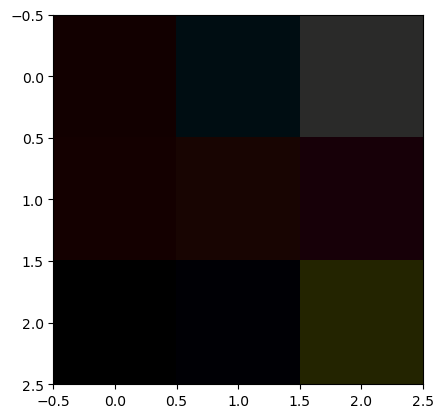

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


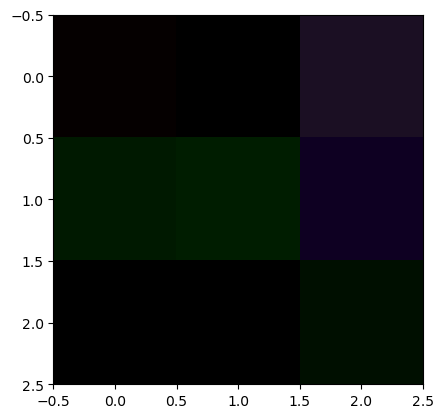

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


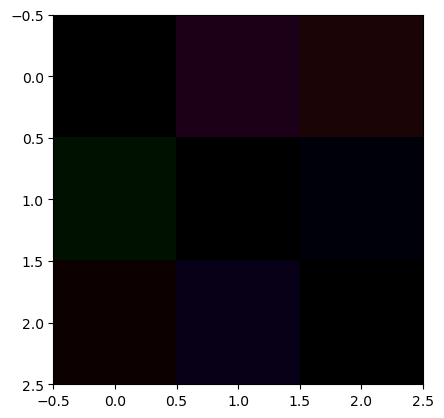

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


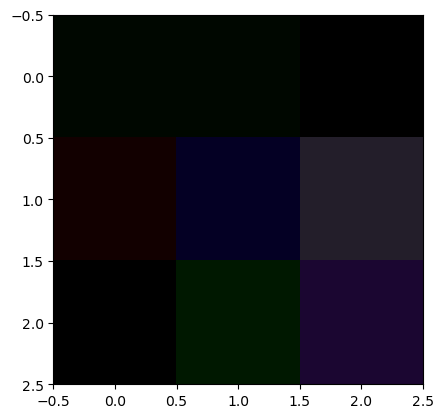

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


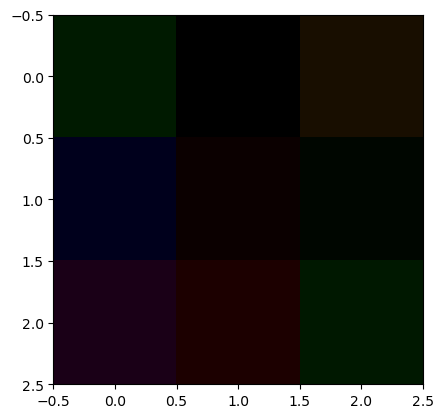

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


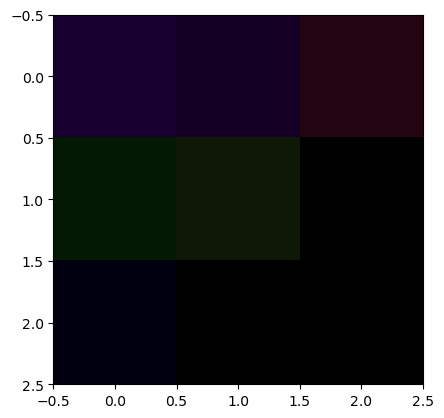

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


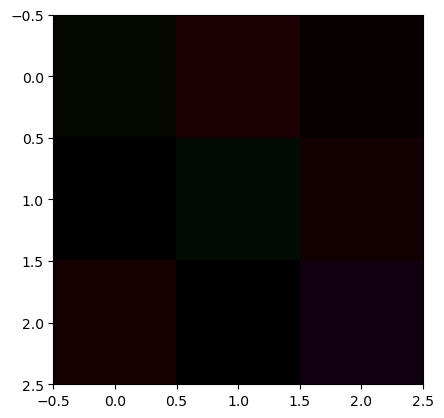

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


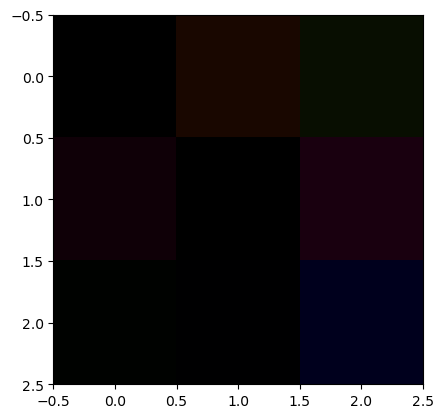

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


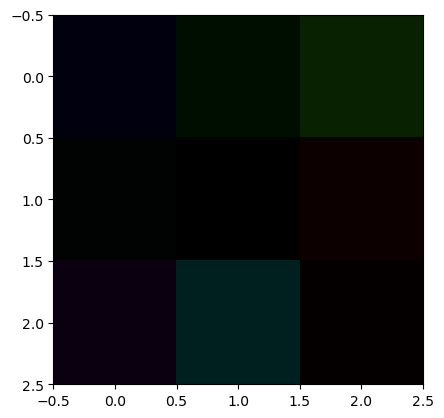

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


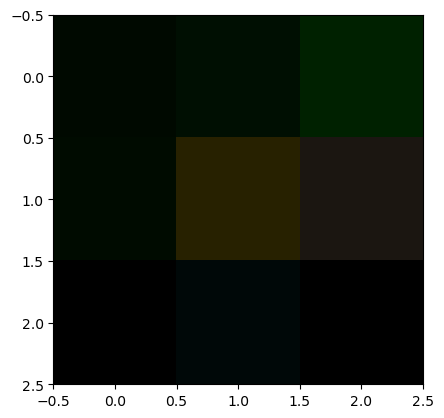

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


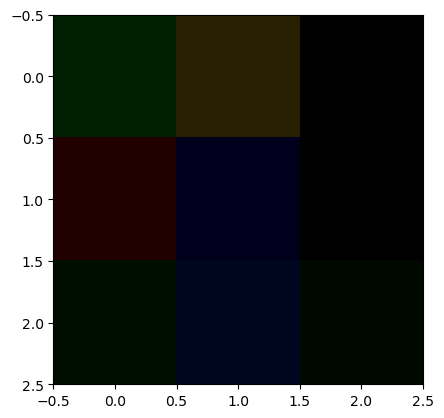

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


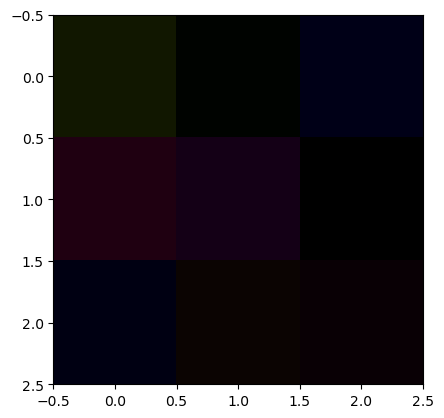

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


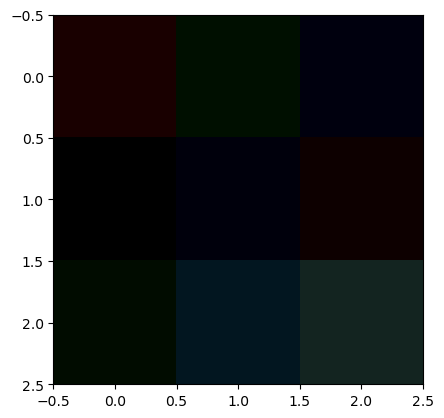

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


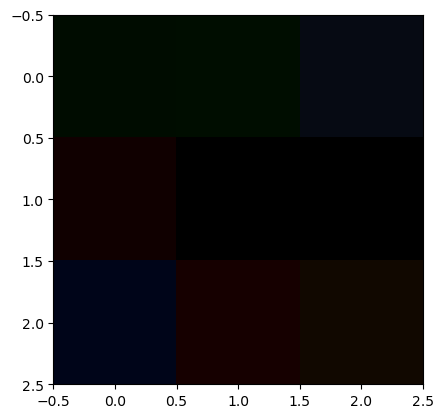

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


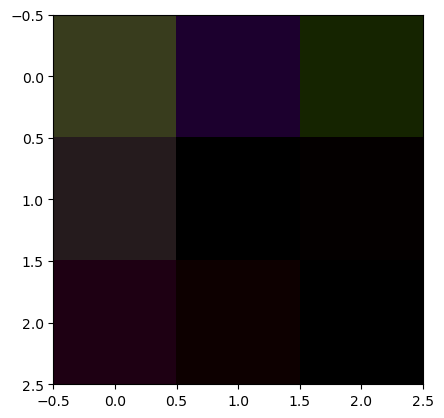

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


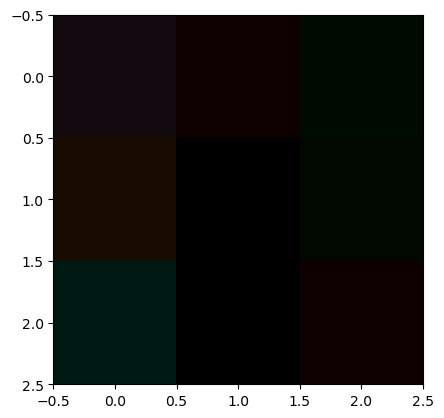

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


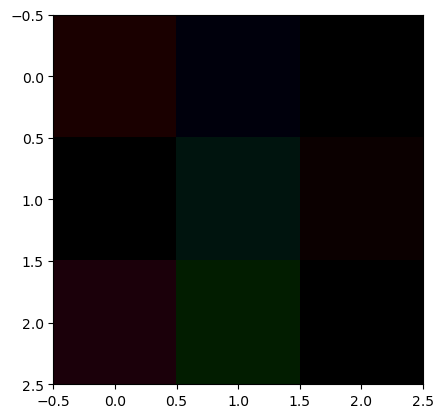

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


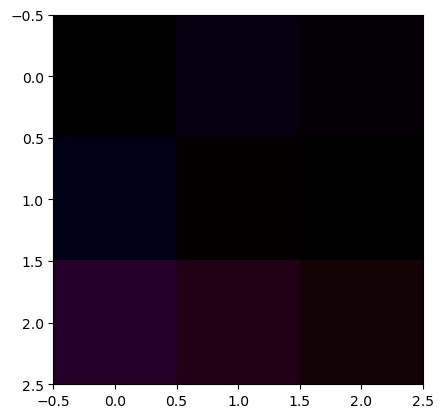

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


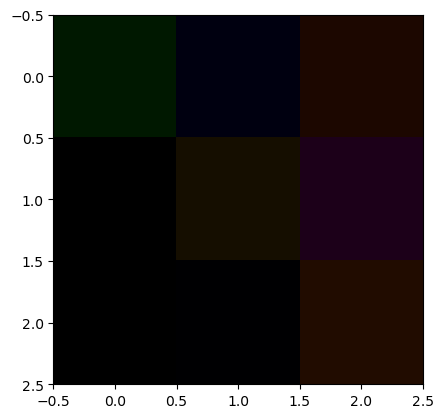

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


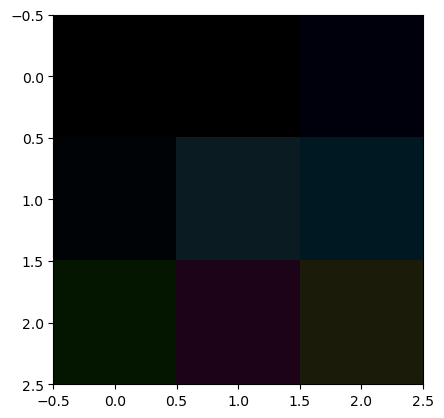

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


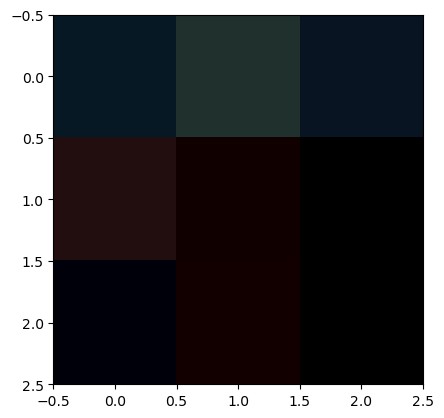

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


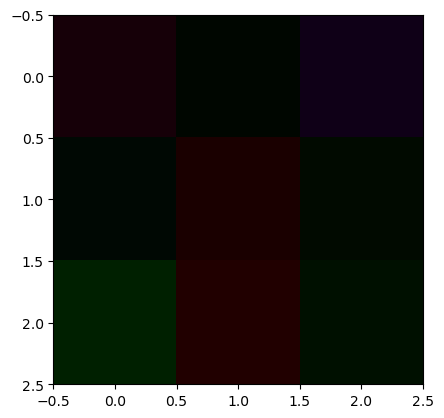

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


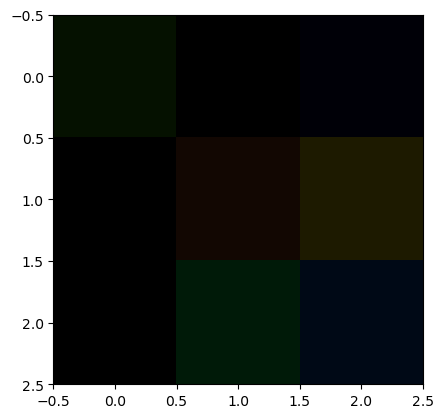

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


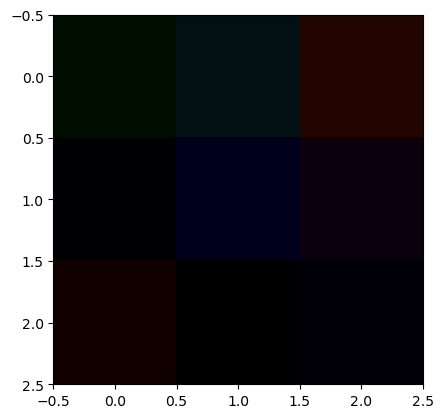

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


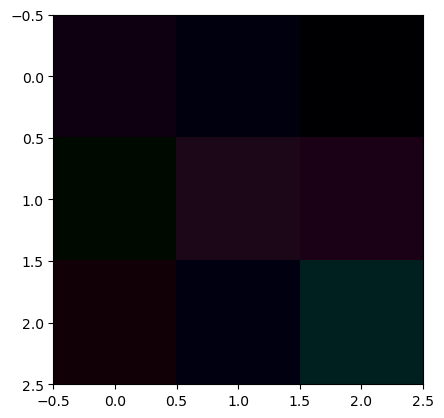

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


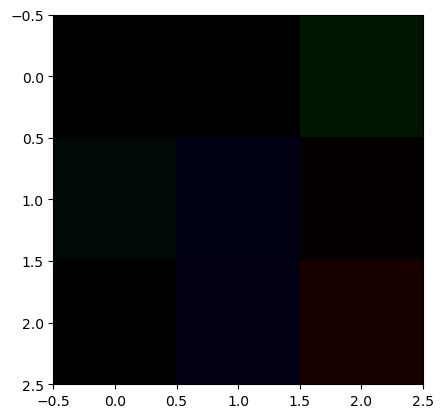

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


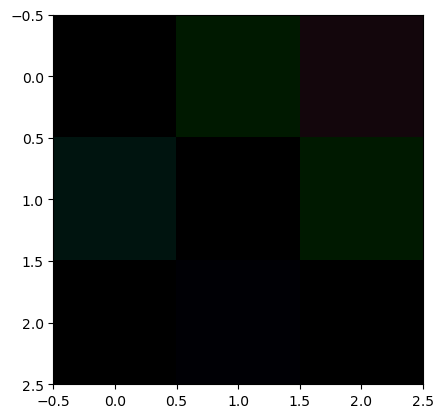

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


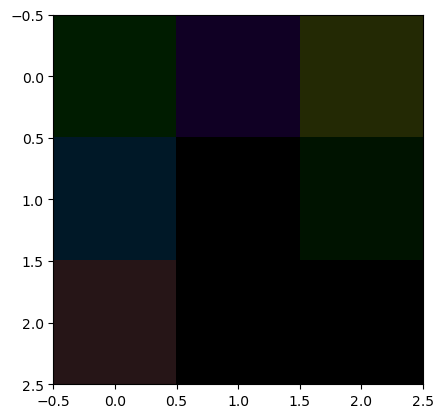

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


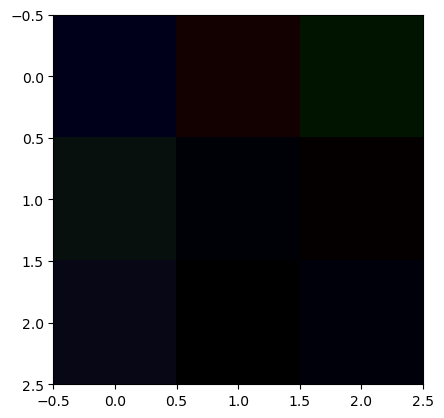

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


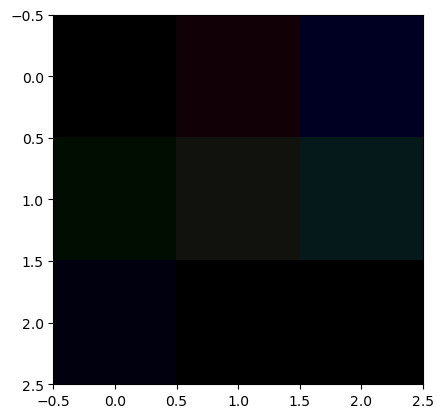

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


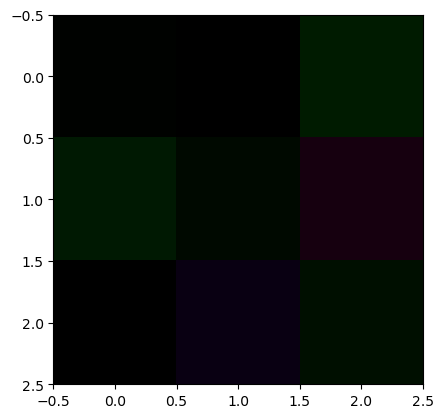

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


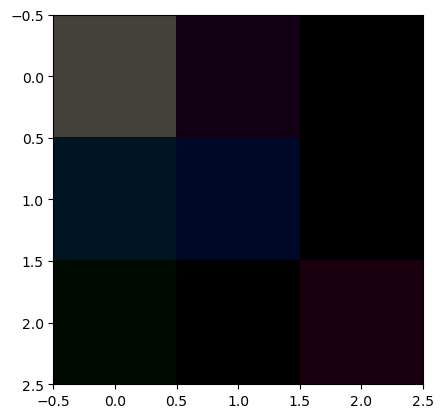

In [6]:
cw1 = np.array(model.layers[1].get_weights())
for i in range(32):
  plt.imshow(cw1[0][:,:,:,i])
  plt.show()